In [1]:
import pandas as pd
import numpy as np
import tejapi
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 解決MAC電腦 plot中文問題
plt.rcParams['axes.unicode_minus'] = False
tejapi.ApiConfig.api_key = "Your Key"
tejapi.ApiConfig.ignoretz = True

In [2]:
data=tejapi.get('TWN/ANPRCSTD' ,chinese_column_name=True )
select=data["上市別"].unique()
select=select[1:3]
condition =(data["上市別"].isin(select)) & ( data["證券種類名稱"]=="普通股" )
data=data[condition]
twid=data["證券碼"].to_list()  #取得上市櫃股票證券碼

In [3]:
def get_data(code:str, id_):
    df = tejapi.get(code, #從TEJ api撈取所需要的資料
                  chinese_column_name = True,
                  paginate = True,
                  mdate = {'gt':'2013-04-01', 'lt':'2021-12-31'},
                  coid=id_,
                  opts={'columns':['coid','mdate','close_adj']})
    return df

In [4]:
def get_data1(code:str, id_):
    df = tejapi.get(code, #從TEJ api撈取所需要的資料
                  chinese_column_name = True,
                  paginate = True,
                  mdate = {'gt':'2013-04-01', 'lt':'2021-12-31'},
                  coid=id_,
                  opts={'columns':['coid','annd_s', 'd0003', 'd0004']})
    return df

In [ ]:
# df_1 = tejapi.get('TWN/APRCD1', #從TEJ api撈取所需要的資料
#                   chinese_column_name = True,
#                   paginate = True,
#                   mdate = {'gt':'2013-04-01', 'lt':'2021-12-31'},
#                   coid=1101,
#                   opts={'columns':['coid','mdate','close_adj']})

In [ ]:
# df = tejapi.get('TWN/ASALE', #從TEJ api撈取所需要的資料
#                 chinese_column_name = True,
#                 paginate = True,
#                 mdate = {'gt':'2013-04-01', 'lt':'2021-12-31'},
#                 coid = 1101,
#                 opts={'columns':['coid','annd_s', 'd0003', 'd0004']})

In [ ]:
df_1 = get_data('TWN/APRCD1', i)
df = get_data1('TWN/ASALE', i)
df.rename(columns={'營收發布日':'年月日','單月營收成長率%':'yoy', '單月營收與上月比%':'mom', '公司':'證券代碼'}, inplace=True)
df['yoy3'] = df['yoy'].rolling(5).mean()
df['mom3'] = df['mom'].rolling(10).mean()

df2 = df_1.merge(df, on=['證券代碼', '年月日'], how='outer')
df2 = df2.sort_values(by='年月日')
df2[['yoy', 'mom','yoy3','mom3']] = df2[['yoy', 'mom','yoy3',"mom3"]].shift(1)
df3 = df2.dropna()
df3.set_index(df3['年月日'], inplace=True)
df3.drop(columns={'年月日'}, inplace=True)

In [5]:
def buysell(data, id_):
    data =data.copy()
    buy=[]
    sell=[]
    hold=0
    for i in range(len(data)):
    
        if  (data["yoy"][i] > data["yoy3"][i]) & (data["mom"][i] > data["mom3"][i]):
            sell.append(np.nan)
            if hold !=1:
                buy.append(data["收盤價(元)"][i])
                
                hold = 1
            else: 
                buy.append(np.nan)
        elif (data["yoy"][i] < data["yoy3"][i]) & (data["mom"][i] < data["mom3"][i]):
            buy.append(np.nan)
            if hold !=0:
                sell.append(data["收盤價(元)"][i])
                hold = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    a=(buy,sell)
        
    data['Buy_Signal_Price']=a[0]
    data['Sell_Signal_Price']=a[1]
    data["買賣股數1"]=data['Buy_Signal_Price'].apply(lambda x : 1 if x >0 else 0)
    data["買賣股數2"]=data['Sell_Signal_Price'].apply(lambda x : -1 if x >0 else 0  )
    data["買賣股數"]=data["買賣股數1"]+ data["買賣股數2"]
    
    b = data[['Buy_Signal_Price']].dropna()
    c = data[['Sell_Signal_Price']].dropna()
    d = pd.DataFrame(index=c.index, columns = {"Buy_Signal_Price", 'Sell_Signal_Price'})
    for i in range(len(d.index)):
        d["Buy_Signal_Price"][i] = b["Buy_Signal_Price"][i]
        d['Sell_Signal_Price'][i] = c['Sell_Signal_Price'][i]
    d['hold_return'] = (d['Sell_Signal_Price']-d['Buy_Signal_Price'])/d['Buy_Signal_Price']
    win_rate = ((np.where(d['hold_return']>0, 1, 0).sum())/len(d.index))*100
    hold_ret = (d['hold_return'].sum())*100
    e = pd.DataFrame({'報酬':hold_ret, '勝率':win_rate}, index={str(id_)}) 
    return e

In [ ]:
qq = pd.DataFrame()
for i in twid[:]:
    df_1 = get_data("TWN/APRCD1",i)
    df = get_data1("TWN/ASALE",i)
    df.rename(columns={'營收發布日':'年月日','單月營收成長率%':'yoy', '單月營收與上月比%':'mom', '公司':'證券代碼'}, inplace=True)
    df['yoy3'] = df['yoy'].rolling(5).mean()
    df['mom3'] = df['mom'].rolling(10).mean()
    df2 = df_1.merge(df, on=['證券代碼', '年月日'], how='outer')
    df2 = df2.sort_values(by='年月日')
    df2[['yoy', 'mom','yoy3','mom3']] = df2[['yoy', 'mom','yoy3',"mom3"]].shift(1)
    df3 = df2.dropna()
    df3.set_index(df3['年月日'], inplace=True)
    df3.drop(columns={'年月日'}, inplace=True)
    qq = qq.append(buysell(df3, i))
    print(i)
qq.index.name = '證券碼'

In [6]:
qq = pd.read_csv('月營收.csv')

In [7]:
qq = qq.rename(columns={'Unnamed: 0':'證券碼'})

In [8]:
qq['證券碼'] = qq[['證券碼']].applymap(lambda x:str(x))

In [9]:
qq.set_index(qq['證券碼'],inplace=True)

In [10]:
qq.drop(columns={'證券碼'}, inplace = True)

In [11]:
qq

,報酬,勝率
證券碼,,
1101,49.099029,54.545455
1102,55.589627,58.333333
1103,68.876273,60.000000
1104,28.355913,68.750000
1108,12.914957,40.000000
...,...,...
9951,57.428088,57.142857
9955,-29.987316,35.294118
9958,109.106182,45.454545


In [14]:
print(qq.isna().sum())
qq.dropna(inplace=True)

報酬     0
勝率    54
dtype: int64


In [16]:
print('勝率：',qq['勝率'].mean())
print('報酬率：',qq['報酬'].mean())

勝率： 52.03301257275607
報酬率： 66.44750522557626


In [18]:
qq['count'] = np.where( (qq['報酬']>0) &(qq['勝率']>= 50),1,0)
(qq['count'].sum()/qq['count'].count())*100

57.73772529521442

In [19]:
qq['20%'] = np.where((qq['勝率']>= 80),1,0)
qq['40%'] = np.where((qq['勝率']>= 60)& (qq['勝率']< 80),1,0)
qq['60%'] = np.where((qq['勝率']>= 40)& (qq['勝率']< 60),1,0)
qq['80%'] = np.where((qq['勝率']>= 20)& (qq['勝率']< 40),1,0)
qq['100%'] = np.where((qq['勝率']<20),1,0)
z5 = [qq['20%'].sum(),qq['40%'].sum(), qq['60%'].sum(), qq['80%'].sum(),qq['100%'].sum()]

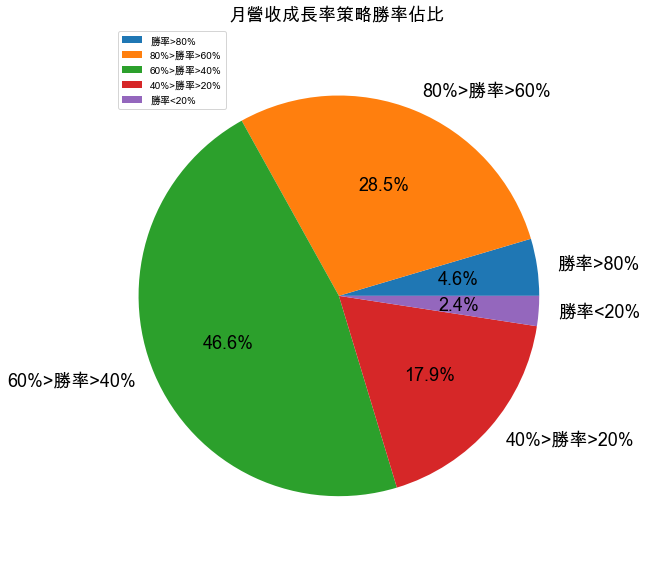

In [20]:
plt.figure(figsize=(8,10))
plt.pie(z5,
        radius=1,
        labels=['勝率>80%','80%>勝率>60%','60%>勝率>40%','40%>勝率>20%','勝率<20%'],
        autopct='%.1f%%',    # %.1f%% 表示顯示小數點一位的浮點數，後方加上百分比符號     
        pctdistance = 0.6,             
        textprops = {"fontsize" : 18})  # 文字大小)   
plt.title('月營收成長率策略勝率佔比', {"fontsize":18})
plt.legend(loc = "best")
plt.axis('equal')
        
plt.show()

In [25]:
len((qq[qq['勝率']>=50]).index)/len(qq.index)

0.6090739589807334